In [19]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import matplotlib.pyplot as plt

end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=365)
data = yf.download('AAPL', start=start_date, end=end_date, interval='1h')
data['Close'] = data['Close'].ffill()

if data.empty:
    raise ValueError("No data retrieved for AAPL. Check the ticker symbol and internet connection.")

x = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values
y = data['Close'].values
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(x)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

def create_dataset(x, time_steps=24):
    x_new = []
    for i in range(time_steps, len(x)):
        x_new.append(x[i-time_steps:i])
    return np.array(x_new)

time_steps = 24
x_new = create_dataset(x_scaled, time_steps)


[*********************100%%**********************]  1 of 1 completed


In [20]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=365)
data = yf.download('AAPL', start=start_date, end=end_date, interval='1h')
data['Close'] = data['Close'].ffill()

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

if not data.empty:
    x = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values
    y = data['Close'].values
    x_scaled = x_scaler.fit_transform(x)
    y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

    def create_dataset(x, time_steps=24):
        x_new = []
        for i in range(time_steps, len(x)):
            x_new.append(x[i-time_steps:i])
        return np.array(x_new)

    time_steps = 24
    x_new = create_dataset(x_scaled, time_steps)
    dataset = TensorDataset(torch.from_numpy(x_new).float(), torch.from_numpy(y_scaled[time_steps:]).float())
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    generator = Generator(input_dim=time_steps, hidden_dim=128, output_dim=time_steps)
    discriminator = Discriminator(input_dim=time_steps)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    epochs = 150
    for epoch in range(epochs):
        for x_batch, _ in train_loader:
            real_data = x_batch.view(-1, time_steps)
            real_labels = torch.ones(real_data.size(0), 1)
            fake_labels = torch.zeros(real_data.size(0), 1)

            discriminator.zero_grad()
            outputs = discriminator(real_data)
            real_loss = criterion(outputs, real_labels)
            noise = torch.randn(real_data.size(0), time_steps)
            fake_data = generator(noise)
            outputs = discriminator(fake_data)
            fake_loss = criterion(outputs, fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()

            generator.zero_grad()
            noise = torch.randn(real_data.size(0), time_steps)
            fake_data = generator(noise)
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')
else:
    print("No data available for model training.")


[*********************100%%**********************]  1 of 1 completed


Epoch [1/150], d_loss: 1.376038670539856, g_loss: 0.5890858173370361
Epoch [2/150], d_loss: 1.3668882846832275, g_loss: 0.9018480777740479
Epoch [3/150], d_loss: 1.306239366531372, g_loss: 0.8093619346618652
Epoch [4/150], d_loss: 1.3143504858016968, g_loss: 0.6808883547782898
Epoch [5/150], d_loss: 1.2931883335113525, g_loss: 1.0114182233810425
Epoch [6/150], d_loss: 1.3365240097045898, g_loss: 0.8113417625427246
Epoch [7/150], d_loss: 1.3070898056030273, g_loss: 0.6957333087921143
Epoch [8/150], d_loss: 1.3730769157409668, g_loss: 0.677797257900238
Epoch [9/150], d_loss: 1.3548243045806885, g_loss: 0.7155951261520386
Epoch [10/150], d_loss: 1.4081698656082153, g_loss: 0.6423681974411011
Epoch [11/150], d_loss: 1.341444492340088, g_loss: 0.7251468300819397
Epoch [12/150], d_loss: 1.398376226425171, g_loss: 0.7089055180549622
Epoch [13/150], d_loss: 1.373786211013794, g_loss: 0.6754580736160278
Epoch [14/150], d_loss: 1.3453700542449951, g_loss: 0.7245429754257202
Epoch [15/150], d_los

Epoch [119/150], d_loss: 1.3972759246826172, g_loss: 0.7009252905845642
Epoch [120/150], d_loss: 1.3463544845581055, g_loss: 0.7117020487785339
Epoch [121/150], d_loss: 1.372767448425293, g_loss: 0.6913184523582458
Epoch [122/150], d_loss: 1.377027153968811, g_loss: 0.7109337449073792
Epoch [123/150], d_loss: 1.3533519506454468, g_loss: 0.7121086120605469
Epoch [124/150], d_loss: 1.3866405487060547, g_loss: 0.6865963339805603
Epoch [125/150], d_loss: 1.436783790588379, g_loss: 0.6782736778259277
Epoch [126/150], d_loss: 1.3749783039093018, g_loss: 0.6707523465156555
Epoch [127/150], d_loss: 1.3457599878311157, g_loss: 0.7252832055091858
Epoch [128/150], d_loss: 1.4164011478424072, g_loss: 0.6922419667243958
Epoch [129/150], d_loss: 1.3707301616668701, g_loss: 0.728333592414856
Epoch [130/150], d_loss: 1.4124972820281982, g_loss: 0.6508437991142273
Epoch [131/150], d_loss: 1.386258840560913, g_loss: 0.6855172514915466
Epoch [132/150], d_loss: 1.421662449836731, g_loss: 0.723320543766021

In [21]:
generator.eval()
noise = torch.randn(1, time_steps)
generated_data = generator(noise)
predicted_prices = y_scaler.inverse_transform(generated_data.detach().numpy().reshape(-1, 1))

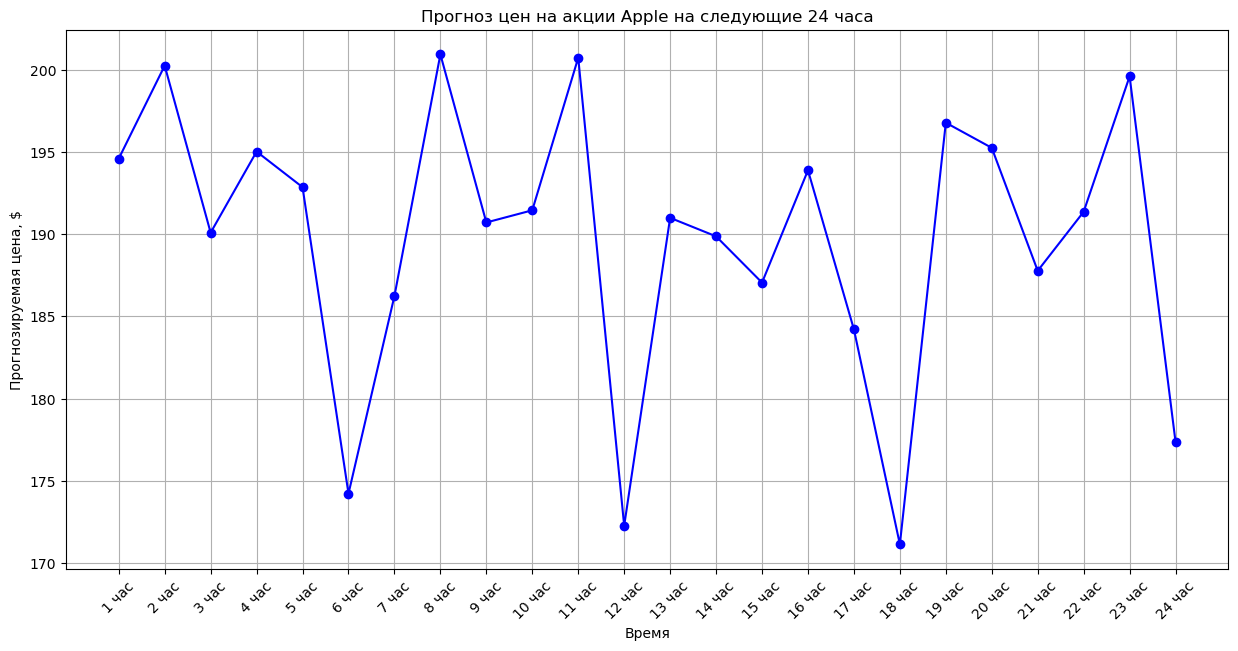

In [22]:
import matplotlib.pyplot as plt

hours = [f"{i+1} час" for i in range(24)]

plt.figure(figsize=(15, 7))
plt.plot(hours, predicted_prices.flatten(), marker='o', linestyle='-', color='blue')
plt.title('Прогноз цен на акции Apple на следующие 24 часа')
plt.xlabel('Время')
plt.ylabel('Прогнозируемая цена, $')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
